# OkCupid 고객 이탈 예측 - ML 모델 학습
    - Data: okcupid_preprocessed_ara_v2.csv(59,934명 x 38컬럼)
    - 목표: churn (이탈여부) 이진분류

데이터 로드

In [54]:
# 1. 라이브러리 & 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, recall_score, precision_score
)
from imblearn.over_sampling import SMOTE

df = pd.read_csv('../data/processed/okcupid_preprocessed_ara_v2.csv')
print(f'데이터 shape: {df.shape}')
print(f'churn 비율:\n{df["churn"].value_counts(normalize=True).round(3)}')


데이터 shape: (59934, 38)
churn 비율:
churn
0    0.92
1    0.08
Name: proportion, dtype: float64


In [55]:
import matplotlib.font_manager as fm  # 한글폰트(굴림체) 설치
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

데이터 분리

In [56]:
# 2. X, y 분리 & Train/Test Split
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'y_train 분포:\n{y_train.value_counts()}')

X_train: (47947, 37), X_test: (11987, 37)
y_train 분포:
churn
0    44127
1     3820
Name: count, dtype: int64


SMOTE (불균형 처리)

In [57]:
# 3. SMOTE - 불균형 처리 (학습데이터에만 적용/test는 실제 데이터 유지)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'SMOTE 전: {X_train.shape} → 이탈 비율: {y_train.mean():.3f}')
print(f'SMOTE 후: {X_train_smote.shape} → 이탈 비율: {y_train_smote.mean():.3f}')

SMOTE 전: (47947, 37) → 이탈 비율: 0.080
SMOTE 후: (88254, 37) → 이탈 비율: 0.500


평가함수정의

In [ ]:
# 4. 평가 함수 정의
def evaluate_model(model_name, y_test, y_pred, y_prob):
    print(f"\n{'='*50}")
    print(f"  {model_name}")
    print(f"{'='*50}")
    print("\n[Classification Report]")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['잔류(0)', '이탈(1)'],
                yticklabels=['잔류(0)', '이탈(1)'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('실제값')
    plt.xlabel('예측값')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model_name,
        'ROC-AUC': round(roc_auc_score(y_test, y_prob), 4),
        'F1': round(f1_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4)
    }


results = []

In [59]:
print(f"데이터 shape: {df.shape}")
print(f"\nchurn 분포:")
print(df['churn'].value_counts())
print(f"\nchurn 비율:")
print(df['churn'].value_counts(normalize=True).round(3))

데이터 shape: (59934, 38)

churn 분포:
churn
0    55159
1     4775
Name: count, dtype: int64

churn 비율:
churn
0    0.92
1    0.08
Name: proportion, dtype: float64


Logistic Regression

train score: 0.748
test score:  0.734

  Logistic Regression

[Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     11032
           1       0.10      0.30      0.15       955

    accuracy                           0.73     11987
   macro avg       0.51      0.54      0.50     11987
weighted avg       0.86      0.73      0.79     11987

ROC-AUC  : 0.5611
F1 Score : 0.1525
Recall   : 0.3005
Precision: 0.1021


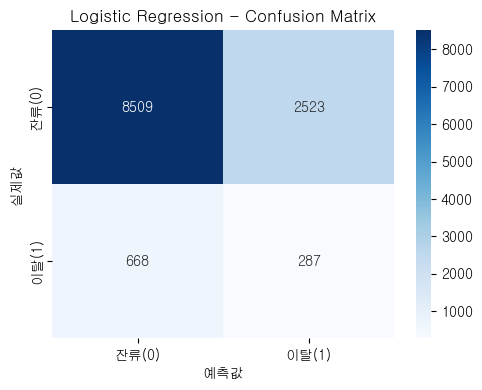

In [60]:
# 5. Logistic Regression 

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_smote, y_train_smote)

print(f'train score: {lr.score(X_train_smote, y_train_smote):.3f}')
print(f'test score:  {lr.score(X_test, y_test):.3f}')

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

result = evaluate_model('Logistic Regression', y_test, y_pred_lr, y_prob_lr)
results.append(result)


Decision Tree

train score: 0.629
test score:  0.582


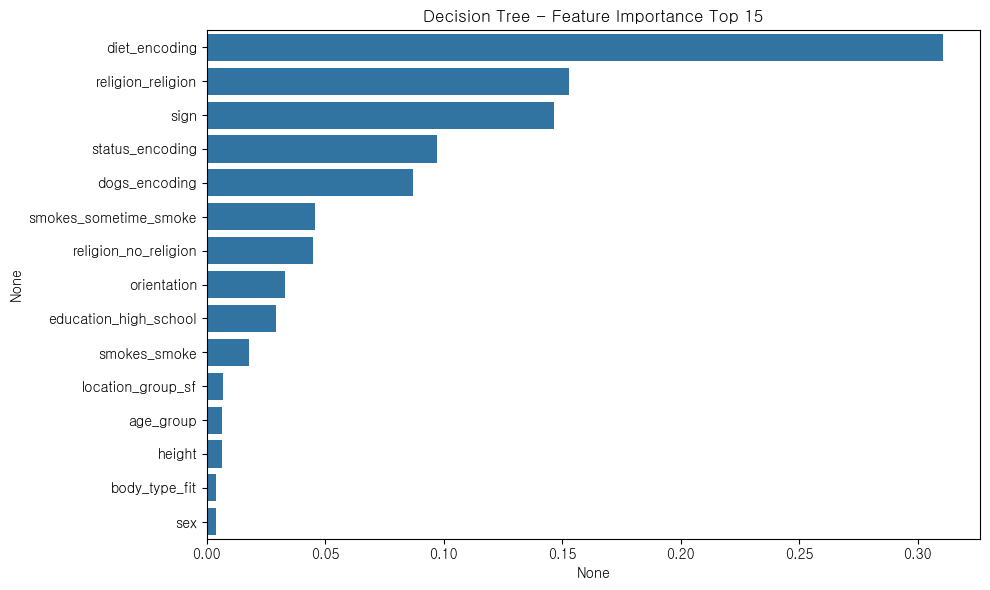


  Decision Tree

[Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     11032
           1       0.09      0.49      0.16       955

    accuracy                           0.58     11987
   macro avg       0.51      0.54      0.44     11987
weighted avg       0.86      0.58      0.68     11987

ROC-AUC  : 0.5596
F1 Score : 0.1580
Recall   : 0.4921
Precision: 0.0941


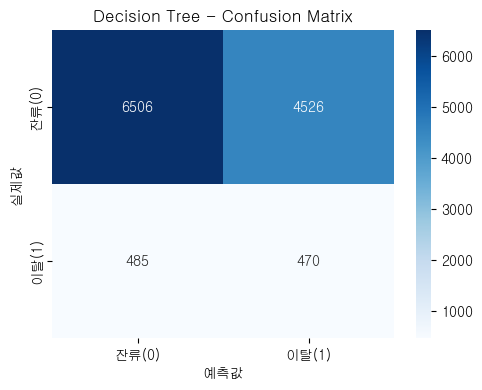

In [61]:
# 6. Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train_smote, y_train_smote)

print(f'train score: {dt.score(X_train_smote, y_train_smote):.3f}')
print(f'test score:  {dt.score(X_test, y_test):.3f}')

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

# 특성 중요도 시각화 
feat_impt = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_impt, y=feat_impt.index)
plt.title('Decision Tree - Feature Importance Top 15')
plt.tight_layout()
plt.show()

result = evaluate_model('Decision Tree', y_test, y_pred_dt, y_prob_dt)
results.append(result)

In [62]:
# Decision Tree 결과 분석

# train score: 0.629   test score: 0.582
# ROC-AUC  : 0.560
# F1 Score : 0.158
# Recall   : 0.492  ← 이탈자 955명 중 470명 잡음
# Precision: 0.094

Random Forest (앙상블학습)

train score: 0.707
test score:  0.630


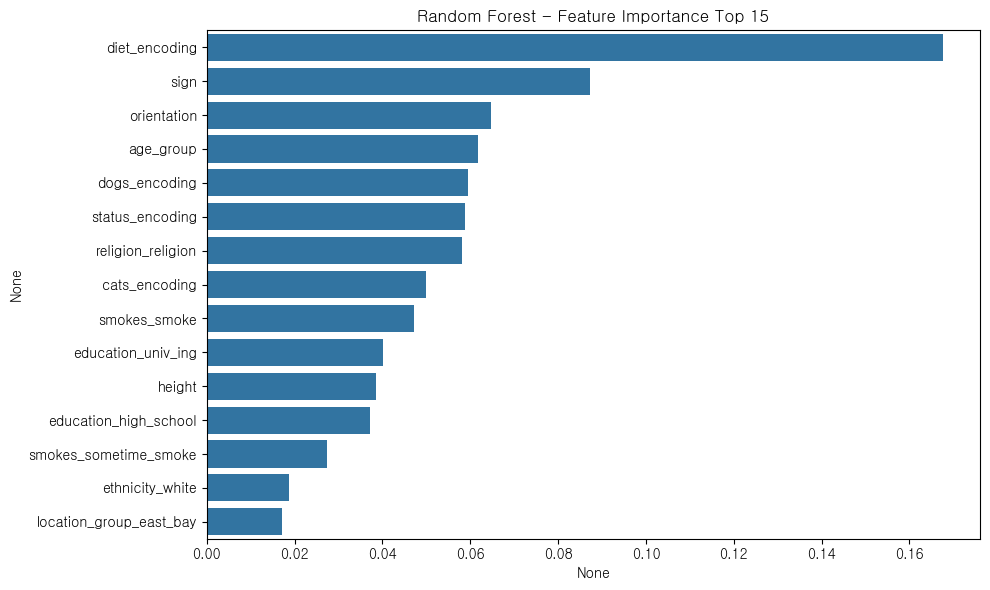


  Random Forest

[Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.65      0.76     11032
           1       0.10      0.46      0.16       955

    accuracy                           0.63     11987
   macro avg       0.52      0.55      0.46     11987
weighted avg       0.87      0.63      0.71     11987

ROC-AUC  : 0.5871
F1 Score : 0.1644
Recall   : 0.4565
Precision: 0.1002


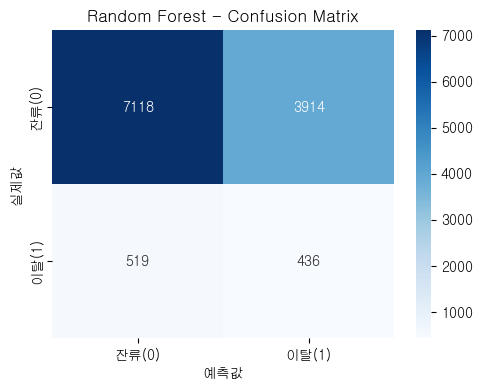

In [63]:
# 7. Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train_smote, y_train_smote)

print(f'train score: {rf.score(X_train_smote, y_train_smote):.3f}')
print(f'test score:  {rf.score(X_test, y_test):.3f}')

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# 특성 중요도 시각화
feat_impt = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_impt, y=feat_impt.index)
plt.title('Random Forest - Feature Importance Top 15')
plt.tight_layout()
plt.show()

result = evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf)
results.append(result)


XGBoost

[0]	validation_0-logloss:0.68687
[1]	validation_0-logloss:0.68178
[2]	validation_0-logloss:0.67719
[3]	validation_0-logloss:0.67315
[4]	validation_0-logloss:0.66966
[5]	validation_0-logloss:0.66656
[6]	validation_0-logloss:0.66317
[7]	validation_0-logloss:0.65976
[8]	validation_0-logloss:0.65648
[9]	validation_0-logloss:0.65406
[10]	validation_0-logloss:0.65139
[11]	validation_0-logloss:0.64924
[12]	validation_0-logloss:0.64715
[13]	validation_0-logloss:0.64459
[14]	validation_0-logloss:0.64237
[15]	validation_0-logloss:0.63952
[16]	validation_0-logloss:0.63639
[17]	validation_0-logloss:0.63463
[18]	validation_0-logloss:0.63268
[19]	validation_0-logloss:0.62663
[20]	validation_0-logloss:0.62457
[21]	validation_0-logloss:0.62281
[22]	validation_0-logloss:0.62028
[23]	validation_0-logloss:0.61886
[24]	validation_0-logloss:0.61726
[25]	validation_0-logloss:0.61553
[26]	validation_0-logloss:0.61387
[27]	validation_0-logloss:0.61251
[28]	validation_0-logloss:0.60769
[29]	validation_0-loglos

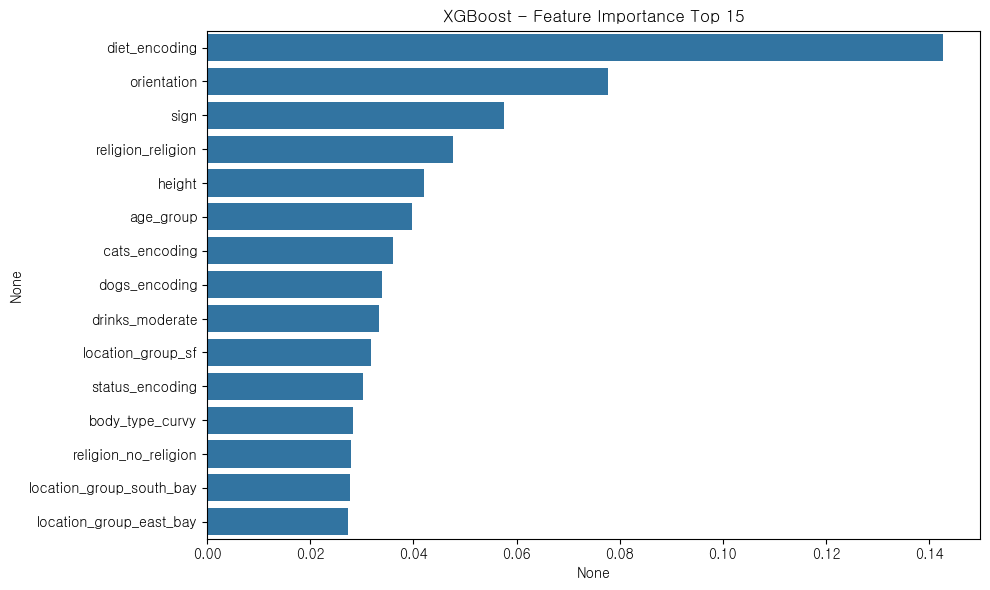


  XGBoost

[Classification Report]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     11032
           1       0.18      0.02      0.03       955

    accuracy                           0.92     11987
   macro avg       0.55      0.51      0.49     11987
weighted avg       0.86      0.92      0.88     11987

ROC-AUC  : 0.5883
F1 Score : 0.0325
Recall   : 0.0178
Precision: 0.1848


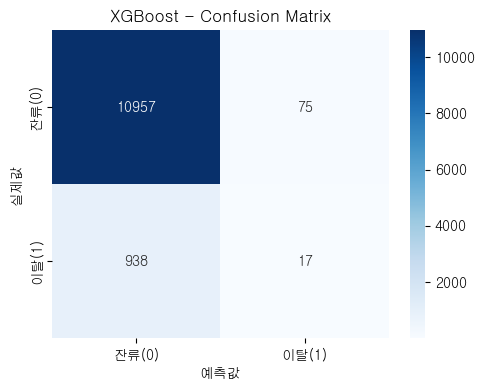

In [64]:
# 8. XGBoost 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split as tts

# 검증 데이터 분리 
X_tr, X_eval, y_tr, y_eval = tts(X_train_smote, y_train_smote, test_size=0.1, random_state=42)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    early_stopping_rounds=10,
    eval_metric='logloss',
    verbosity=0
)

xgb.fit(X_tr, y_tr, eval_set=[(X_eval, y_eval)])

print(f'train score: {xgb.score(X_tr, y_tr):.3f}')
print(f'test score:  {xgb.score(X_test, y_test):.3f}')

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# 특성 중요도 시각화
feat_impt = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_impt, y=feat_impt.index)
plt.title('XGBoost - Feature Importance Top 15')
plt.tight_layout()
plt.show()

result = evaluate_model('XGBoost', y_test, y_pred_xgb, y_prob_xgb)
results.append(result)

LightGBM

train score: 0.928
test score:  0.916


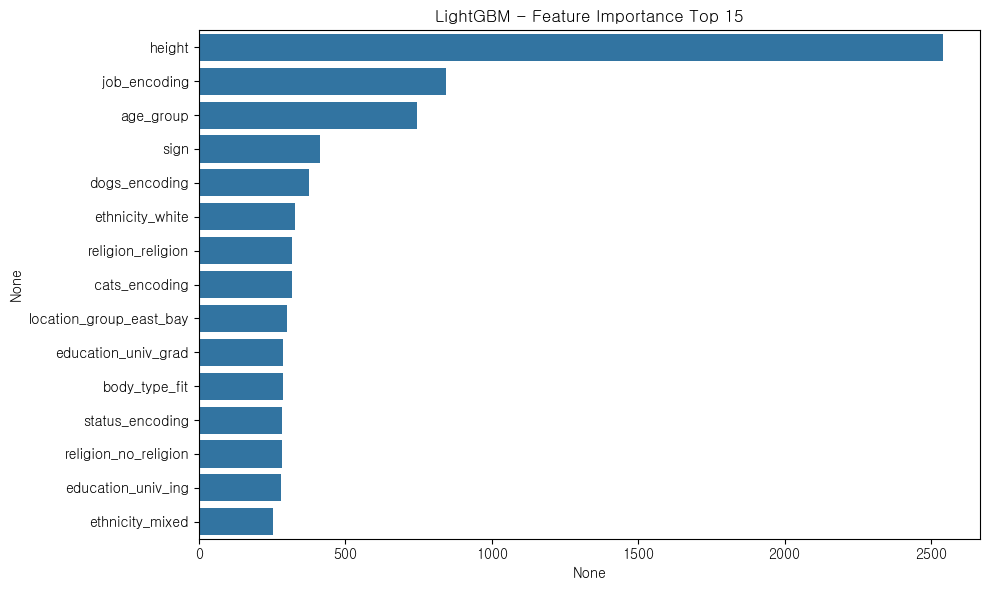


  LightGBM

[Classification Report]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     11032
           1       0.19      0.01      0.03       955

    accuracy                           0.92     11987
   macro avg       0.56      0.50      0.49     11987
weighted avg       0.86      0.92      0.88     11987

ROC-AUC  : 0.5926
F1 Score : 0.0272
Recall   : 0.0147
Precision: 0.1892


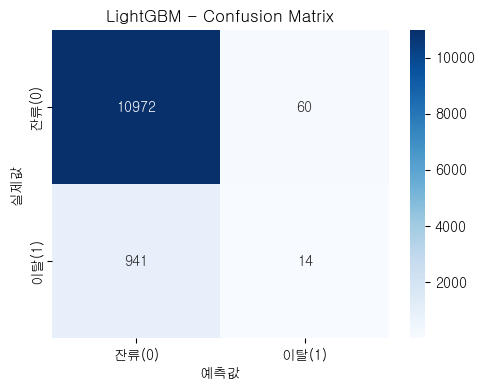

In [65]:
# 9. LightGBM
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    early_stopping_rounds=20,
    verbose=-1
)

eval_set = [(X_tr, y_tr), (X_eval, y_eval)]
lgbm.fit(X_tr, y_tr, eval_set=eval_set)

print(f'train score: {lgbm.score(X_tr, y_tr):.3f}')
print(f'test score:  {lgbm.score(X_test, y_test):.3f}')

y_pred_lgbm = lgbm.predict(X_test)
y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]

# 특성 중요도 시각화
feat_impt = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_impt, y=feat_impt.index)
plt.title('LightGBM - Feature Importance Top 15')
plt.tight_layout()
plt.show()

result = evaluate_model('LightGBM', y_test, y_pred_lgbm, y_prob_lgbm)
results.append(result)

CatBoost

In [ ]:
# !pip install catboost

train score: 0.929
test score:  0.916


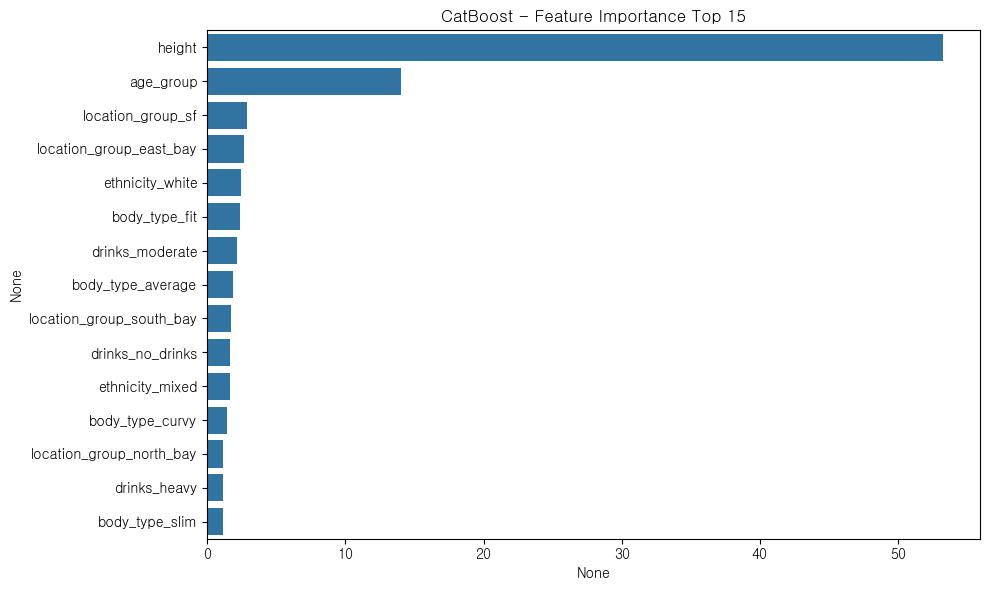


  CatBoost

[Classification Report]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     11032
           1       0.15      0.01      0.02       955

    accuracy                           0.92     11987
   macro avg       0.53      0.50      0.49     11987
weighted avg       0.86      0.92      0.88     11987

ROC-AUC  : 0.5975
F1 Score : 0.0196
Recall   : 0.0105
Precision: 0.1471


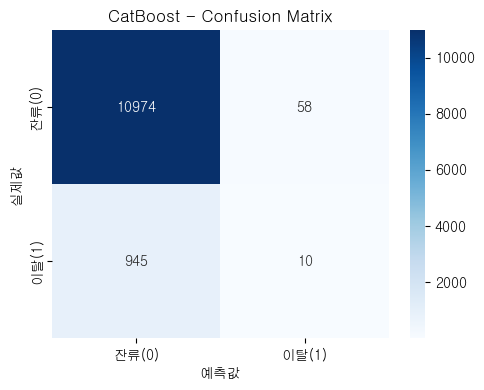

In [67]:
# 10. CatBoost
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=5,
    random_seed=42,
    early_stopping_rounds=20,
    verbose=0
)

cat.fit(X_tr, y_tr, eval_set=(X_eval, y_eval))

print(f'train score: {cat.score(X_tr, y_tr):.3f}')
print(f'test score:  {cat.score(X_test, y_test):.3f}')

y_pred_cat = cat.predict(X_test)
y_prob_cat = cat.predict_proba(X_test)[:, 1]

# 특성 중요도 시각화
feat_impt = pd.Series(cat.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_impt, y=feat_impt.index)
plt.title('CatBoost - Feature Importance Top 15')
plt.tight_layout()
plt.show()

result = evaluate_model('CatBoost', y_test, y_pred_cat, y_prob_cat)
results.append(result)

모델 성능 비교


===== 모델 성능 비교 (Recall 기준 정렬) =====
              model  ROC-AUC     F1  Recall  Precision
      Decision Tree   0.5596 0.1580  0.4921     0.0941
      Random Forest   0.5871 0.1644  0.4565     0.1002
Logistic Regression   0.5611 0.1525  0.3005     0.1021
            XGBoost   0.5883 0.0325  0.0178     0.1848
           LightGBM   0.5926 0.0272  0.0147     0.1892
           CatBoost   0.5975 0.0196  0.0105     0.1471


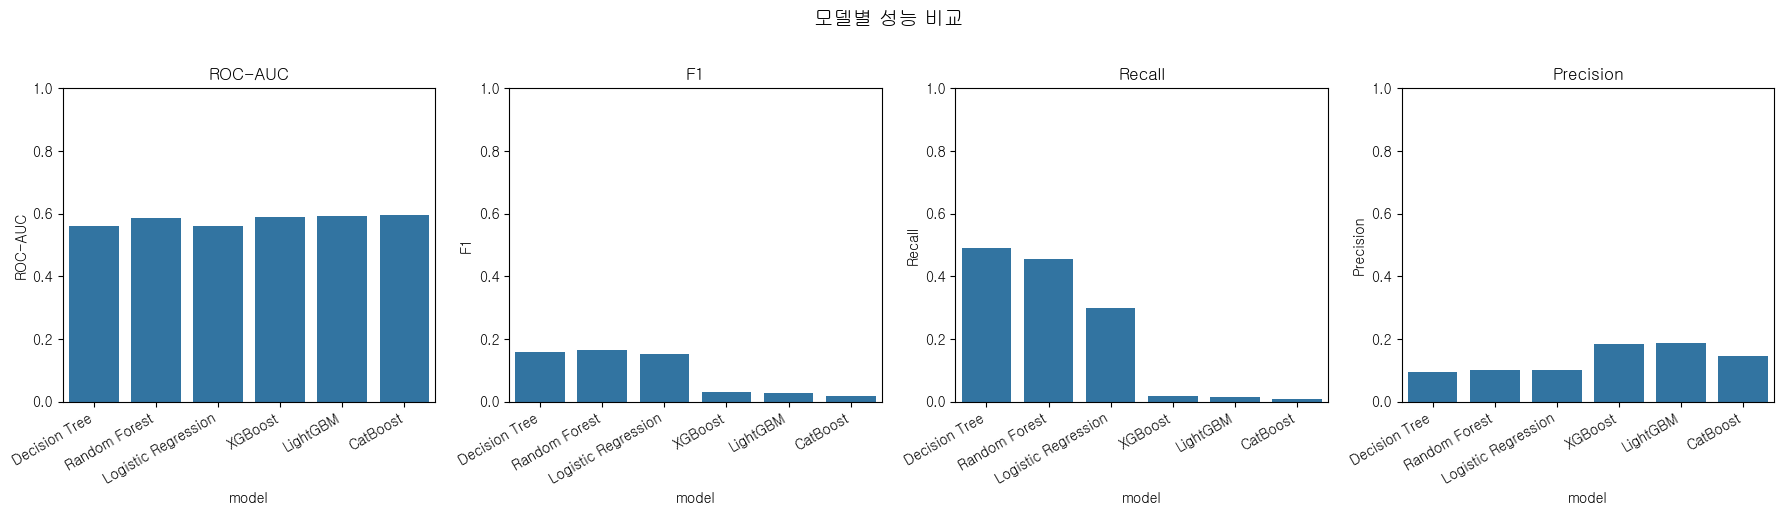

결과 저장 완료! → results/model_comparison.csv


In [71]:
# 11. 모델 성능 비교표
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Recall', ascending=False).reset_index(drop=True)

print('\n===== 모델 성능 비교 (Recall 기준 정렬) =====')
print(results_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
metrics = ['ROC-AUC', 'F1', 'Recall', 'Precision']

for ax, metric in zip(axes, metrics):
    sns.barplot(data=results_df, x='model', y=metric, ax=ax)
    ax.set_title(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.suptitle('모델별 성능 비교', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

import os
os.makedirs('../results', exist_ok=True)
results_df.to_csv('../results/model_comparison.csv', index=False)
print('결과 저장 완료! → results/model_comparison.csv')

최종 모델 저장 (joblib)

In [72]:
# 12. 최종 모델 선정 및 저장

from joblib import dump, load

# Recall 기준 최고 모델 저장
best_model_name = results_df.iloc[0]['model']
print(f'최고 모델: {best_model_name}')

model_map = {
    'Logistic Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'CatBoost': cat
}

best_model = model_map[best_model_name]
dump(best_model, f'../models/best_model_{best_model_name.lower().replace(" ", "_")}.joblib')
print(f'model saved')

# 저장 확인
loaded = load(f'../models/best_model_{best_model_name.lower().replace(" ", "_")}.joblib')
print(f'로드 확인: {np.array_equal(best_model.predict(X_test), loaded.predict(X_test))}')


최고 모델: Decision Tree
model saved
로드 확인: True


### 전체 모델 성능 비교

| 모델 | Recall | F1 | ROC-AUC | Precision |
| :--- | :--- | :--- | :--- | :--- |
| Decision Tree | 0.492 | 0.158 | 0.560 | 0.094 |
| Random Forest | 0.457 | 0.164 | 0.587 | 0.100 |
| Logistic Regression | 0.301 | 0.153| 0.561 | 0.102 |
| XGBoost | 0.018 | 0.033 | 0.588 | 0.185 |
| LightGBM | 0.015 | 0.027 | 0.593 | 0.189 |
| CatBoost | 0.011 | 0.020 | 0.598 | 0.147 |

- XGBoost / LightGBM / CatBoost -> Recall이 0.01 - 0.02
    - 이탈자 거의 못 잡음
    - 원인: SMOTE 데이터를 eval_set으로 사용해서..
    - early_stopping이 SMOTE된 데이터 기준으로 조기 종료
    - 원본 불균형 패턴 학습못함